In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xarray as xr
from scipy.stats import pearsonr
from pypalettes import load_cmap

# Import data

## Mixed-freq. data

In [70]:
# Import jet shift data (Screen 2022)
jet_responses = pd.read_csv('/home/links/ct715/eddy_feedback/chapter1/daily_efp/data/jet_responses_screen2022.csv')

# Import EFP data
og_efp = pd.read_csv('/home/links/ct715/eddy_feedback/chapter1/efp_random/data/non-regridded_efp_AWI-fabricated.csv', index_col=0)
og_efp['model'] = og_efp['model'].replace({'ECHAM6.3': 'AWI-CM-1-1-MR'})

# merge datasets
og = pd.merge(jet_responses, og_efp, on='model', how='outer')
og = og.dropna(subset=['efp_sh', 'efp_nh', 'NH_response']).reset_index(drop=True)
og

,model,SH_response,NH_response,efp_nh,efp_sh
0,AWI-CM-1-1-MR,NaN,-0.492325,0.3724,0.4354
1,CESM1-WACCM-SC,-0.030533,-0.445972,0.1297,0.0295
2,CESM2,-0.242725,-0.643093,0.3693,0.3419
3,CNRM-CM6-1,NaN,-0.604725,0.2421,0.2082
4,CanESM5,-0.569641,-0.755676,0.4256,0.4618
5,E3SMv1,-0.040096,-0.223373,0.0543,0.0542
6,FGOALS-f3-L,0.125217,-0.323620,0.2354,0.1274
7,HadGEM3-GC31-LL,-0.246933,-0.430347,0.2730,0.2951
8,HadGEM3-GC31-MM,-0.205715,-0.784420,0.3137,0.3002
9,IPSL-CM6A-LR,-0.132912,-0.450916,0.2719,0.1959


## Daily-mean EFP data

In [71]:
efp_df = pd.read_csv('/home/links/ct715/eddy_feedback/chapter1/efp_random/data/daily_efp_8models.csv', index_col=0)

efp = pd.merge(jet_responses, efp_df, on='model', how='outer')
efp = efp.dropna(subset=['efp_sh', 'efp_nh']).reset_index(drop=True)
efp

,model,SH_response,NH_response,efp_nh,efp_sh
0,AWI-CM-1-1-MR,NaN,-0.492325,0.2592,0.2557
1,CNRM-CM6-1,NaN,-0.604725,0.2244,0.1944
2,CanESM5,-0.569641,-0.755676,0.3133,0.3271
3,FGOALS-f3-L,0.125217,-0.323620,0.2353,0.1273
4,HadGEM3-GC31-LL,-0.246933,-0.430347,0.1735,0.1729
5,HadGEM3-GC31-MM,-0.205715,-0.784420,0.2525,0.1874
6,IPSL-CM6A-LR,-0.132912,-0.450916,0.2623,0.2015
7,MIROC6,-0.128574,-0.383339,0.1592,0.2058


# Plotting

In [72]:
# Load colormap from pypalettes
cmap = load_cmap("Rainbow")

# Generate a unique set of models
all_models = sorted(set(og['model']).union(set(efp['model'])))

# Colors (already done)
colors = [cmap(i / (len(all_models) - 1)) for i in range(len(all_models))]
palette = dict(zip(all_models, colors))

# Create a consistent marker mapping
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', 'd', 'p', '*']  # extend if needed
markers = dict(zip(all_models, marker_styles * ((len(all_models) // len(marker_styles)) + 1)))

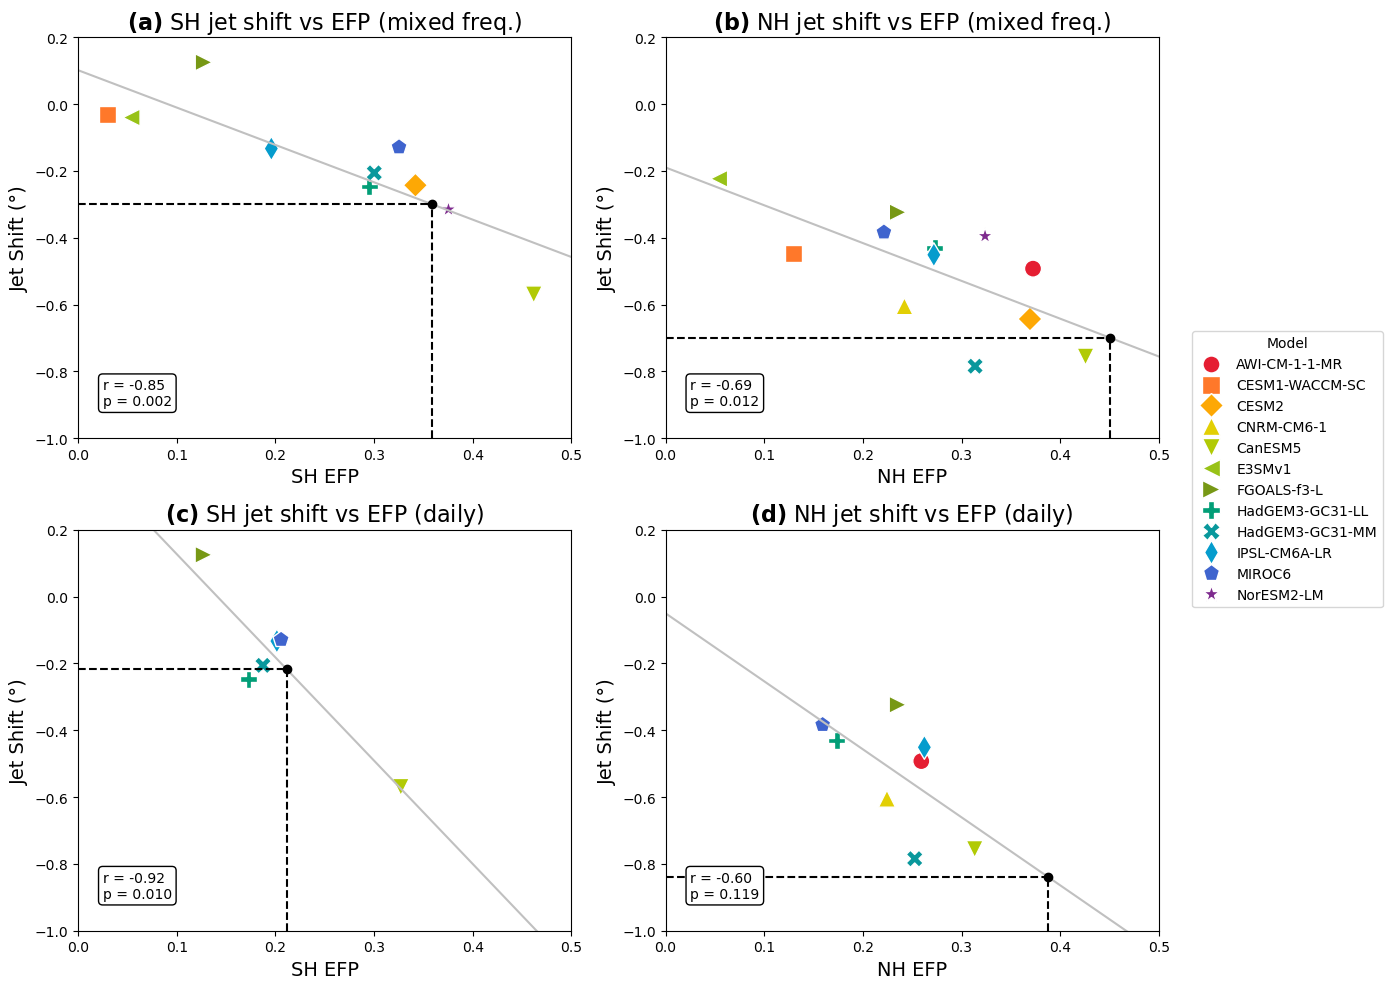

In [73]:
# DataFrames and plot settings
dfs = [og, efp]
responses = ['SH_response', 'NH_response']
efp_cols = ['efp_sh', 'efp_nh']
titles = ['SH jet shift vs EFP (mixed freq.)', 'NH jet shift vs EFP (mixed freq.)', 'SH jet shift vs EFP (daily)', 'NH jet shift vs EFP (daily)']
subplots = ['(a)', '(b)', '(c)', '(d)']

# Value at which to project onto regression line
x_val = np.array([0.3584, 0.4502, 0.2116, 0.3872]) # jra55_sh_6h, jra55_nh_6h, jra55_sh_day, jra55_nh_day


# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, df in enumerate(dfs):
    for j, (resp, efp_col) in enumerate(zip(responses, efp_cols)):

        ax_idx = i*2 + j
        ax = axes[ax_idx]
        
        # Mask to drop NaNs for correlation
        mask = df[[efp_col, resp]].dropna()
        r, p = pearsonr(mask[efp_col], mask[resp])
        
        # Scatter plot
        sns.scatterplot(
            data=df,
            x=efp_col,
            y=resp,
            hue='model',
            style='model',
            palette=palette,
            markers=markers,
            s=150,
            ax=ax
        )
        
        # Get current axis limits
        ax.set_xlim(0, 0.5)
        ax.set_ylim(-1.0, 0.2)
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        # Fit regression line using numpy
        if len(mask) > 1:  # only fit if there are enough points
            coef = np.polyfit(mask[efp_col], mask[resp], 1)  # slope, intercept
            poly1d_fn = np.poly1d(coef)

            # Plot regression line across axis limits
            ax.plot([x_min, x_max],
                    [poly1d_fn(x_min), poly1d_fn(x_max)],
                    color="silver", linestyle="-")

            # Add vertical + horizontal projection lines
            y_val = poly1d_fn(x_val[ax_idx])
            if y_min <= y_val <= y_max:  # only draw if inside y-range
                # vertical line
                ax.plot([x_val[ax_idx], x_val[ax_idx]], [y_min, y_val], color="black", linestyle="--")
                # horizontal line
                ax.plot([x_min, x_val[ax_idx]], [y_val, y_val], color="black", linestyle="--")
                # mark the point
                ax.scatter([x_val[ax_idx]], [y_val], color="black", zorder=5)
        
        ax.set_title(f'$\\bf{subplots[ax_idx]}$ '+ titles[ax_idx], fontsize=16)
        ax.text(
            0.05, 0.15,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white")
        )
        ax.get_legend().remove()  # remove individual legends
        
        ax.set_ylabel('Jet Shift (°)', fontsize=14)
        
        if ax_idx in [1,3]:  # Right column
            ax.set_xlabel('NH EFP', fontsize=14)
        else:
            ax.set_xlabel('SH EFP', fontsize=14)

# Add a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:len(all_models)], all_models, title='Model', bbox_to_anchor=(0.85, 0.67), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# Matching models in both rows

In [74]:
og_cut = og[og['model'].isin(efp['model'])].reset_index(drop=True)
og_cut

,model,SH_response,NH_response,efp_nh,efp_sh
0,AWI-CM-1-1-MR,NaN,-0.492325,0.3724,0.4354
1,CNRM-CM6-1,NaN,-0.604725,0.2421,0.2082
2,CanESM5,-0.569641,-0.755676,0.4256,0.4618
3,FGOALS-f3-L,0.125217,-0.323620,0.2354,0.1274
4,HadGEM3-GC31-LL,-0.246933,-0.430347,0.2730,0.2951
5,HadGEM3-GC31-MM,-0.205715,-0.784420,0.3137,0.3002
6,IPSL-CM6A-LR,-0.132912,-0.450916,0.2719,0.1959
7,MIROC6,-0.128574,-0.383339,0.2213,0.3253


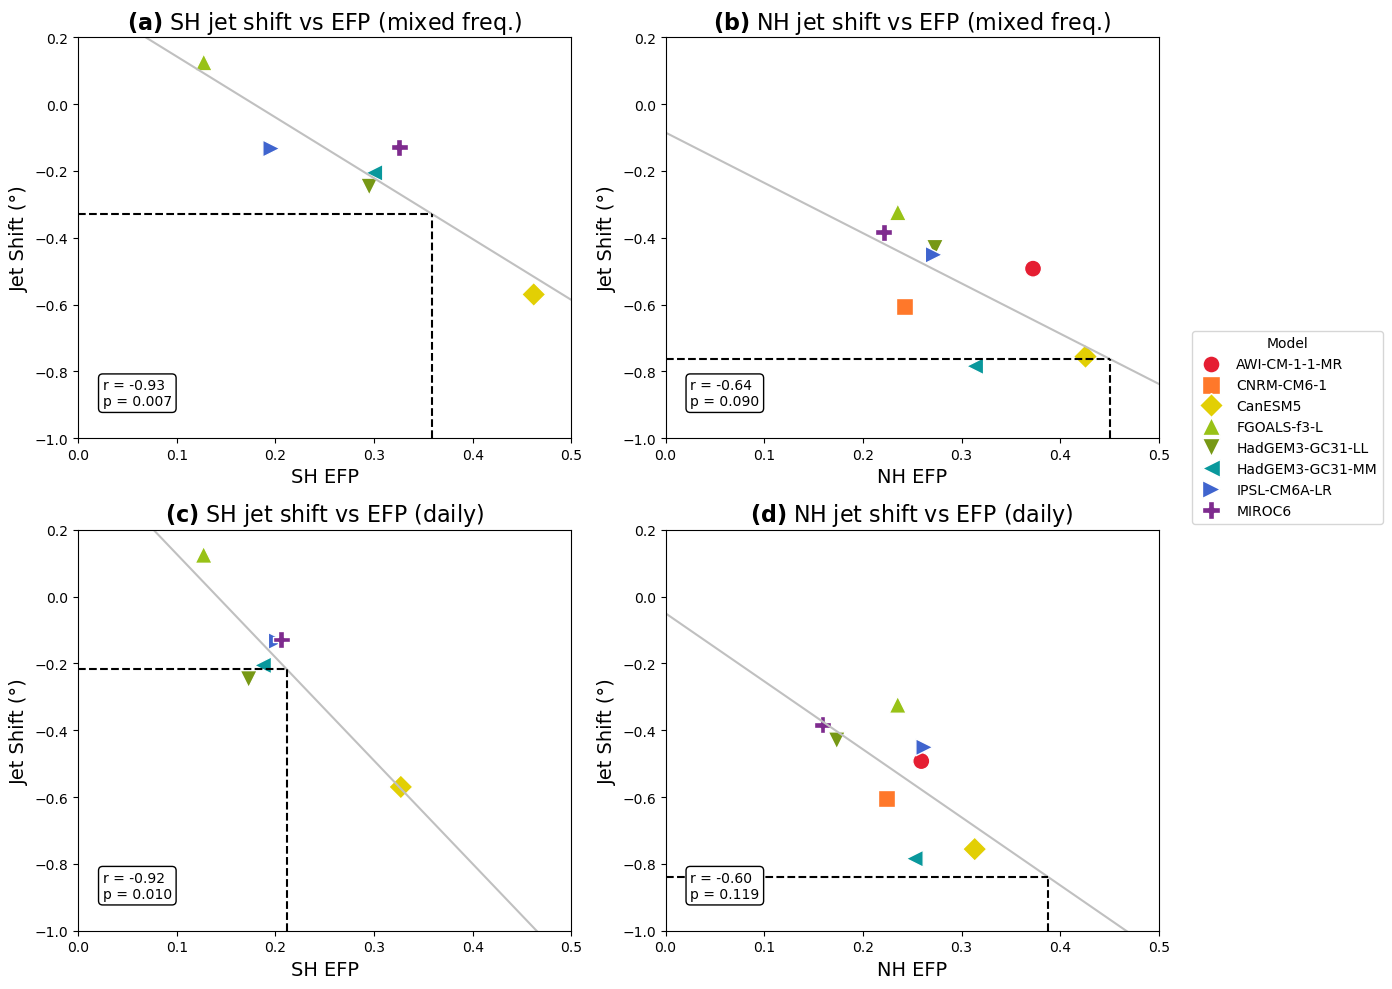

In [75]:
# DataFrames and plot settings
dfs = [og_cut, efp]
responses = ['SH_response', 'NH_response']
efp_cols = ['efp_sh', 'efp_nh']
titles = ['SH jet shift vs EFP (mixed freq.)', 'NH jet shift vs EFP (mixed freq.)', 'SH jet shift vs EFP (daily)', 'NH jet shift vs EFP (daily)']
subplots = ['(a)', '(b)', '(c)', '(d)']

# Load colormap from pypalettes
cmap = load_cmap("Rainbow")

# Generate a unique set of models
all_models = sorted(set(og_cut['model']).union(set(efp['model'])))

# Colors (already done)
colors = [cmap(i / (len(all_models) - 1)) for i in range(len(all_models))]
palette = dict(zip(all_models, colors))

# Create a consistent marker mapping
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']  # extend if needed
markers = dict(zip(all_models, marker_styles * ((len(all_models) // len(marker_styles)) + 1)))

# Value at which to project onto regression line
x_val = np.array([0.3584, 0.4502, 0.2116, 0.3872]) # jra55_sh_6h, jra55_nh_6h, jra55_sh_day, jra55_nh_day


# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, df in enumerate(dfs):
    for j, (resp, efp_col) in enumerate(zip(responses, efp_cols)):

        ax_idx = i*2 + j
        ax = axes[ax_idx]
        
        # Mask to drop NaNs for correlation
        mask = df[[efp_col, resp]].dropna()
        r, p = pearsonr(mask[efp_col], mask[resp])
        
        # Scatter plot
        sns.scatterplot(
            data=df,
            x=efp_col,
            y=resp,
            hue='model',
            style='model',
            palette=palette,
            markers=markers,
            s=150,
            ax=ax
        )
        
        # Get current axis limits
        ax.set_xlim(0, 0.5)
        ax.set_ylim(-1.0, 0.2)
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        # Fit regression line using numpy
        if len(mask) > 1:  # only fit if there are enough points
            coef = np.polyfit(mask[efp_col], mask[resp], 1)  # slope, intercept
            poly1d_fn = np.poly1d(coef)

            # Plot regression line across axis limits
            ax.plot([x_min, x_max],
                    [poly1d_fn(x_min), poly1d_fn(x_max)],
                    color="silver", linestyle="-")

            # Add vertical + horizontal projection lines
            y_val = poly1d_fn(x_val[ax_idx])
            if y_min <= y_val <= y_max:  # only draw if inside y-range
                # vertical line
                ax.plot([x_val[ax_idx], x_val[ax_idx]], [y_min, y_val], color="black", linestyle="--")
                # horizontal line
                ax.plot([x_min, x_val[ax_idx]], [y_val, y_val], color="black", linestyle="--")
                # mark the point
                # ax.scatter([x_val[ax_idx]], [y_val], color="black", zorder=5)
        
        ax.set_title(f'$\\bf{subplots[ax_idx]}$ '+ titles[ax_idx], fontsize=16)
        ax.text(
            0.05, 0.15,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white")
        )
        ax.get_legend().remove()  # remove individual legends
        
        ax.set_ylabel('Jet Shift (°)', fontsize=14)
        
        if ax_idx in [1,3]:  # Right column
            ax.set_xlabel('NH EFP', fontsize=14)
        else:
            ax.set_xlabel('SH EFP', fontsize=14)

# Add a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:len(all_models)], all_models, title='Model', bbox_to_anchor=(0.85, 0.67), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()